# Clustering Analysis

The clustering approach was to first determine clusters using Kmeans and DBSCAN to identify the most similar groups. A medium/high dimensional dataset was used for Kmeans, while a low dimentional dataset of only rodent sightings was used for DBSCAN. The second step was to identify and adjust the hyperparameters to identify anomalies in the dataset. Finally, the results of both approaches are compared. 


In [586]:
from datetime import datetime, timedelta
import geopandas as gpd
import json
import pandas as pd
import mapclassify
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import requests
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from io import StringIO
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
np.set_printoptions(threshold=np.inf)

In [273]:
# Parameters
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'rodents_per_year_merged.csv')  # construct the file path
rodents_df = pd.read_csv(file_path)
print(len(rodents_df))
rodents_df.head()

38958


,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations,MedianHouseholdIncome
0,360050001000,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,360050001000,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,360050001000,2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


# Feature Selection

In [304]:
df = rodents_df.filter(regex='^(?!t_|d_|l_).*')
df_2019 = df[df['year']==2019]
df = df_2019.drop(['year','spatial_id','num_dsny_complaints','num_violations'], axis=1)

In [305]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [393]:
# Choose all columns
cols_all = rodents_gdf.columns[3:-1] # (ALL COLUMNS)

# Cols gathered from pca notebook (ALL IMPORTANT COLUMNS ACROSS FIRST 5 PCAs)
cols_top_5_pca = ['l_Outdoor_sum', 'c_Italian_sum', 'l_Other_sum', 'c_Coffee/Tea_sum', 'subway_count', 'c_American_sum', 'l_Vacant_Space_sum', 'c_Caribbean_sum', 'l_Residential-Mixed_sum', 's_Trash_Unsecure:Street_sum', 'num_violations', 'v_flies_sum', 's_Dog_waste:Street_sum', 's_Trash_Unsecure:Residential_sum', 'v_rats/mice_sum', 's_Dead_Animal:Street_sum', 'c_Bakery Products/Desserts_sum', 's_Trash:Street_sum', 'c_Latin American_sum', 'v_roaches_sum', 's_Trash:Residential_sum', 's_Trash_Time:Street_sum', 'c_Chinese_sum', 's_Trash_Overflowing:Street_sum', 'c_other_sum', 'l_Residential_sum', 'c_Pizza_sum', 's_Illegal_Dumping:Street_sum', 's_Dead_Animal:Residential_sum', 's_Trash_MissedService:Street_sum']

# Cols gathered from pca notebook (ALL IMPORTANT COLUMNS FROM PCA 1)
cols_top_pca = ['num_violations', 'v_rats/mice_sum', 'v_flies_sum', 'c_other_sum', 'v_roaches_sum', 'c_American_sum', 'c_Coffee/Tea_sum', 'c_Chinese_sum', 'c_Italian_sum', 'c_Pizza_sum']

cols = ['num_sightings', 
        's_Illegal_Dumping:Street_sum', 
        's_Trash:Residential_sum', 
        's_Trash:Street_sum', 
        's_Trash_Unsecure:Residential_sum', 
        's_Trash_Unsecure:Street_sum', 
        'subway_count', 
        'v_rats/mice_sum', 
        'v_roaches_sum']

cols_simple = ['num_sightings','v_rats/mice_sum','s_Illegal_Dumping:Street_sum', 's_Trash_Unsecure:Street_sum']

cols = cols_simple

In [394]:
# calculate the correlation matrix
corr_matrix = df_scaled.corr()

# find the fields with the highest correlation to the target variable
target_var = 'num_sightings'
corr_values = corr_matrix[target_var]
highest_corr_fields = list(corr_values[corr_values.abs() > 0.05].index)
print(highest_corr_fields)

# create a new dataframe with only the selected fields
df_new = df_scaled[cols]
df_new.head()

['num_sightings', 's_Illegal_Dumping:Street_sum', 's_Trash:Residential_sum', 's_Trash:Street_sum', 's_Trash_Unsecure:Residential_sum', 's_Trash_Unsecure:Street_sum', 'subway_count', 'v_rats/mice_sum', 'v_roaches_sum']


,num_sightings,v_rats/mice_sum,s_Illegal_Dumping:Street_sum,s_Trash_Unsecure:Street_sum
0,0.000000,0.0,0.000000,0.0
1,0.000000,0.0,0.000000,0.0
2,0.000000,0.0,0.000000,0.0
3,0.026667,0.0,0.145161,0.0
4,0.020000,0.0,0.354839,0.0


# K Means

Silhouette score is highest for the following k's 2, 3, and 6 

6 is the most interesting clustering 

In [395]:
# Range of k values to try
k_values = range(2, 11)

# Loop over k values and compute silhouette score for each, and inertia
for k in k_values:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_new)
    # Compute silhouette score
    score = silhouette_score(df_new, kmeans.labels_)
    # Compute Inertia 
    inertia = kmeans.inertia_
    print(f"For k={k}, silhouette score={score:.3f}, inertia:{inertia:.3f}")

For k=2, silhouette score=0.659, inertia:52.838
For k=3, silhouette score=0.583, inertia:34.174
For k=4, silhouette score=0.512, inertia:27.998
For k=5, silhouette score=0.520, inertia:22.875
For k=6, silhouette score=0.546, inertia:20.179
For k=7, silhouette score=0.448, inertia:17.564
For k=8, silhouette score=0.464, inertia:15.453
For k=9, silhouette score=0.462, inertia:14.123
For k=10, silhouette score=0.474, inertia:12.810


In [524]:
# Choosing k=7 for the number of clusters
clusters = 6

In [525]:
# Fit KMeans model
kmeans = KMeans(n_clusters=clusters, random_state=42).fit(df_new)

# Add cluster labels to original dataframe
df_2019['cluster'] = kmeans.labels_

In [526]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(file_path)  # load the GeoJSON file into a GeoDataFrame
rodents_df['spatial_id'] = rodents_df['spatial_id'].astype(str)
rodents_joined_tracts_gdf = pd.merge(cb_gdf[['geometry','spatial_id']], df_2019, how='left')


<AxesSubplot:>

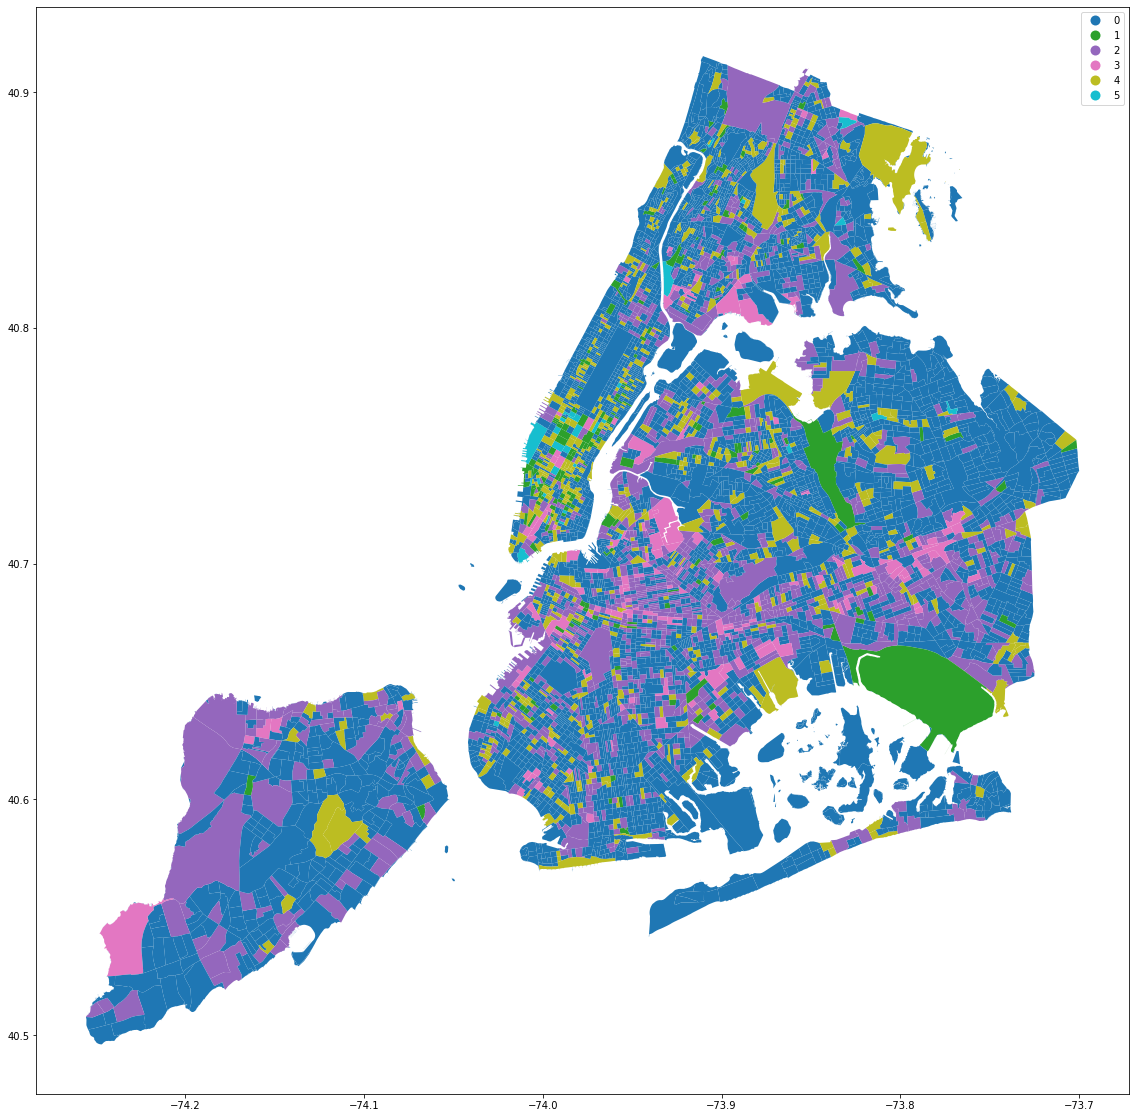

In [527]:
rodents_joined_tracts_gdf.plot(column='cluster', cmap='tab10', categorical=True, figsize=(20, 20), legend=True)

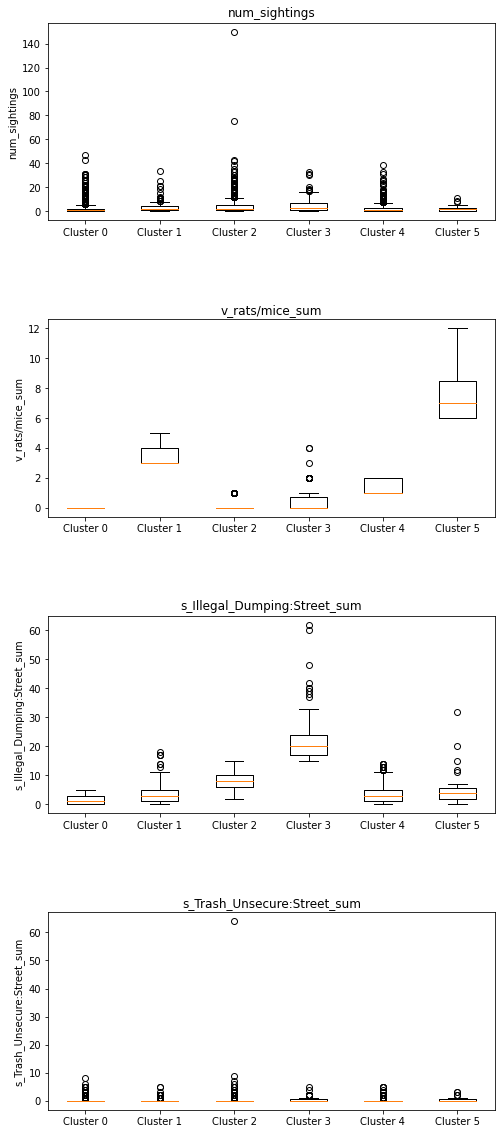

In [533]:
# Set up subplots for each variable
fig, axs = plt.subplots(nrows=len(cols_simple), figsize=(8, 5*len(cols_simple)))
plt.subplots_adjust(hspace=0.5)

# Loop over variables and create box and whisker plot for each
for i, col in enumerate(cols_simple):
    # Create a list of dataframes for each cluster
    cluster_dfs = []
    for cluster_num in range(0, clusters):
        cluster_df = rodents_joined_tracts_gdf[rodents_joined_tracts_gdf['cluster'] == cluster_num]
        cluster_dfs.append(cluster_df)
    
        
    # Plot box and whisker for each cluster
    axs[i].boxplot([df[col] for df in cluster_dfs])
    cluster_labels = ['Cluster {}'.format(i) for i in range(clusters)]
    axs[i].set_xticklabels(cluster_labels)
    axs[i].set_title(col)
    axs[i].set_ylabel(col)  
plt.show()

In [536]:
rodents_joined_tracts_gdf.groupby(['cluster'])[cols_simple].mean().reset_index()

# todo include the number of census blocks 

,cluster,num_sightings,v_rats/mice_sum,s_Illegal_Dumping:Street_sum,s_Trash_Unsecure:Street_sum
0,0,1.757860,0.000000,1.530033,0.122243
1,1,3.364103,3.497436,3.856410,0.271795
2,2,4.155517,0.080799,8.354474,0.315378
3,3,5.000000,0.413333,22.040000,0.353333
4,4,2.768466,1.362216,3.198864,0.177557
5,5,2.290323,7.548387,5.451613,0.483871


Cluster investigation 

Cluster 0: Lowest values of sightings, illegal dumping, and unsecured trash (no restuarant violations - likely this is all residential)

Cluster 1: Second highest restuarant violations with moderate number of rat sightings

Cluster 2: Moderate illegal dumping & second highest category of rat sightings. 

Cluster 3*: Illegal dumping + Highest rat sightings

Cluster 4:Low restaurant violations, moderate illegal dumping and low street unsecured trash 

Cluster 5: High Restaurant violations + high illegal dumping (interesing that the mean number of sightings is not higher 2.29) 

In [583]:
# Set up the subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

# Loop over the clusters and create a map for each
for i in range(6):
    # Create a map for the current cluster
    ax = axs[i//3, i%3]
    cluster_data = rodents_joined_tracts_gdf[rodents_joined_tracts_gdf['cluster'] == i]
    other_data = rodents_joined_tracts_gdf[rodents_joined_tracts_gdf['cluster'] != i]
    other_data.plot(color='lightgray', ax=ax)
    cluster_data.plot(column='cluster', cmap='tab10', categorical=True, legend=False, ax=ax)
    ax.set_title(f'Cluster {i}')
    ax.set_axis_off()

plt.tight_layout()


# Save the figure as a PNG file
plt.savefig('rodent_kmeans_clusters.png', dpi=150, bbox_inches='tight')
plt.close()


# Show the plot
plt.show()


# KMeans Anomalies

In [565]:
# Fit a k-means model
kmeans = KMeans(n_clusters=9, random_state=123).fit(df_new)

# Calculate the distance of each point to its nearest cluster center
distances = kmeans.transform(df_new)
min_distances = np.min(distances, axis=1)

# Set a threshold for the minimum distance
threshold = np.percentile(min_distances, 99)

# Identify anomalies as points with minimum distance above the threshold
anomalies = df_new[min_distances > threshold]

df_2019['kmeans_dist'] = min_distances
df_2019['is_kmeans_anomaly'] = df_2019.apply(lambda x: True if x['kmeans_dist'] > threshold else False, axis=1)

# Print the number of anomalies
print("Number of anomalies:", len(anomalies))

Number of anomalies: 65


In [566]:
df_2019.head()

,spatial_id,year,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations,MedianHouseholdIncome,cluster,kmeans_dist,is_kmeans_anomaly
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.008938,False
10,360050001001,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.008938,False
16,360050002000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.008938,False
22,360050002001,2019,4.0,0.0,4.0,0.0,9.0,10.0,2.0,5.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40196.019522,2,0.029876,False
28,360050002002,2019,3.0,0.0,1.0,0.0,22.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47662.679687,3,0.105243,False


In [584]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(file_path)  # load the GeoJSON file into a GeoDataFrame
rodents_df['spatial_id'] = rodents_df['spatial_id'].astype(str)
rodents_2019_gdf = pd.merge(cb_gdf[['geometry','spatial_id']], df_2019, how='left')

# Define the custom colormap
cmap_custom = ListedColormap(['lightgray', 'red'])

# Create the plot with the custom colormap
fig, ax = plt.subplots(figsize=(6, 6))
rodents_2019_gdf.plot(column='is_kmeans_anomaly', 
                 categorical=True,
                 cmap=cmap_custom, # use the custom colormap
                 ax=ax,
                 linewidth=0.01,
                 legend=True)

# Save the figure as a PNG file
plt.savefig('rodent_kmeans_anomalies.png', dpi=150, bbox_inches='tight')
plt.close()

plt.show()

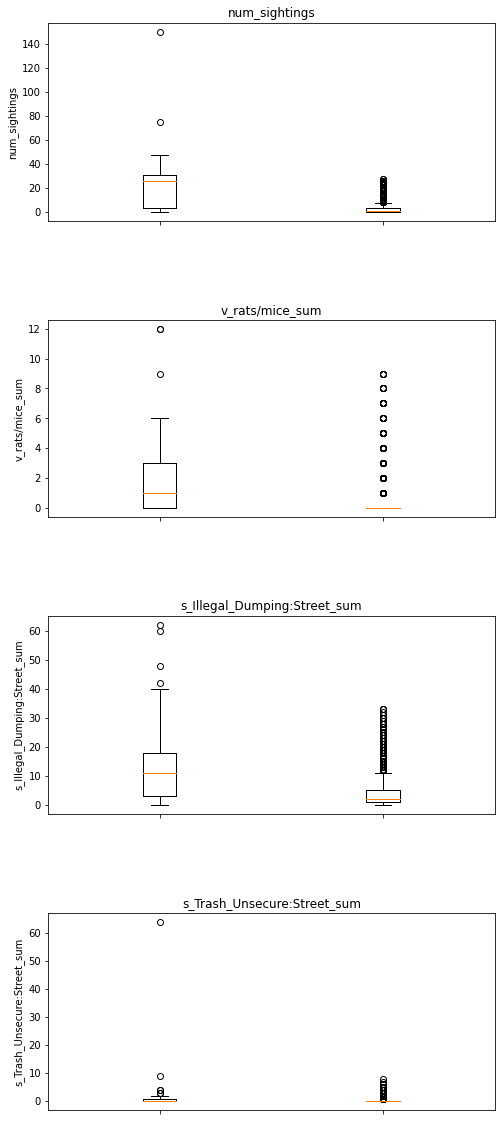

In [568]:
# Set up subplots for each variable
fig, axs = plt.subplots(nrows=len(cols_simple), figsize=(8, 5*len(cols_simple)))
plt.subplots_adjust(hspace=0.5)

# Loop over variables and create box and whisker plot for each
for i, col in enumerate(cols_simple):
    # Create a list of dataframes for each cluster
    group_dfs = []
    group = [True, False]
    for group in group:
        group_df = rodents_2019_gdf[rodents_2019_gdf['is_kmeans_anomaly'] == group]
        group_dfs.append(group_df)
        
    # Plot box and whisker for each cluster
    axs[i].boxplot([df[col] for df in group_dfs])
    cluster_labels = ['Cluster {}'.format(str(i)) for i in range(group)]
    axs[i].set_xticklabels(cluster_labels)
    axs[i].set_title(col)
    axs[i].set_ylabel(col)
    
plt.show()

In [571]:
rodents_2019_gdf.groupby(['is_kmeans_anomaly'])[cols_simple].mean().reset_index().transpose()

,0,1
is_kmeans_anomaly,False,True
num_sightings,2.211263,22.876923
v_rats/mice_sum,0.297604,1.8
s_Illegal_Dumping:Street_sum,3.372278,14.446154
s_Trash_Unsecure:Street_sum,0.158681,1.692308


# DBSCAN 

DBScan is useful for finding clusters based on geographic location. Typically this is done with a low dimentional dataset, typically just latitude and longitude plus perhaps one variable. We attempted to use many more columns, but the result had low [insert cluster eval type and results]. One caveat for our analysis is that we are using an aggrgate count of rodent sightings per census block for which the centroid latitude and longitude was derived. 

The first step was to transform the geographic units to an equal distance projection so that distances between the latitudes and longitudes are equivalent, without any distortion from projections. 

To determine the appropriate vlaus for espeilon and the number of minimum samples, an iterative approach was used.

The silhouette score measures how well each data point fits into its assigned cluster compared to other clusters. 
A score close to 1 indicates that the data point is assigned to the correct cluster, 
while a score close to -1 indicates that the data point is assigned to the wrong cluster.

The Calinski-Harabasz index measures the ratio of between-cluster variance to within-cluster variance. 
A higher score indicates that the clusters are well-separated.

The Davies-Bouldin index measures the average similarity between each cluster and its most similar cluster. 
A lower score indicates that the clusters are well-separated.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm that groups together data points based on their density in a given feature space. The algorithm works by identifying clusters of points that are closely packed together, separated by areas of lower point density. Unlike other clustering algorithms like K-means, DBSCAN can identify clusters of arbitrary shapes and is robust to noise.

Clusters with -1 are 'noise'

In [479]:

rodents_joined_tracts_gdf['rats_weighted'] = (rodents_joined_tracts_gdf['num_sightings']*5) + \
                                    (np.sqrt(rodents_joined_tracts_gdf['v_rats/mice_sum']) + \
                                     np.sqrt(rodents_joined_tracts_gdf['s_Illegal_Dumping:Street_sum']) + \
                                     np.sqrt(rodents_joined_tracts_gdf['s_Trash_Unsecure:Street_sum']) )



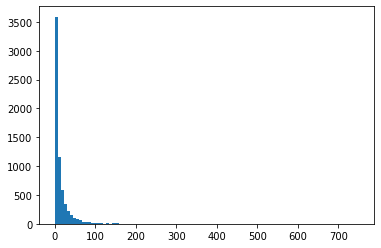

In [480]:
plot = plt.hist(rodents_joined_tracts_gdf['rats_weighted'], bins=100)

In [481]:
rodents_joined_tracts_gdf.sort_values(by='rats_weighted', ascending=False).head(5)

,geometry,spatial_id,year,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations,MedianHouseholdIncome,cluster,rats_weighted
1648,"POLYGON ((-73.96611 40.67424, -73.96369 40.673...",360470215003,2019,150.0,0.0,2.0,0.0,2.0,2.0,8.0,2.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47992.314309,2,751.414214
1649,"POLYGON ((-73.96719 40.67369, -73.96350 40.672...",360470215004,2019,75.0,0.0,1.0,0.0,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173337.690401,2,377.000000
4096,"POLYGON ((-73.96690 40.80182, -73.96522 40.801...",360610195005,2019,47.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75918.088549,0,235.000000
6383,"POLYGON ((-74.13997 40.61231, -74.13973 40.613...",360850189011,2019,42.0,0.0,9.0,0.0,7.0,30.0,5.0,86.0,1.0,0.0,3.0,64.0,205.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78479.410530,2,220.645751
1391,"POLYGON ((-73.99438 40.67140, -73.99202 40.670...",360470117001,2019,43.0,0.0,2.0,1.0,3.0,3.0,7.0,9.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144766.905422,2,216.732051


<AxesSubplot:>

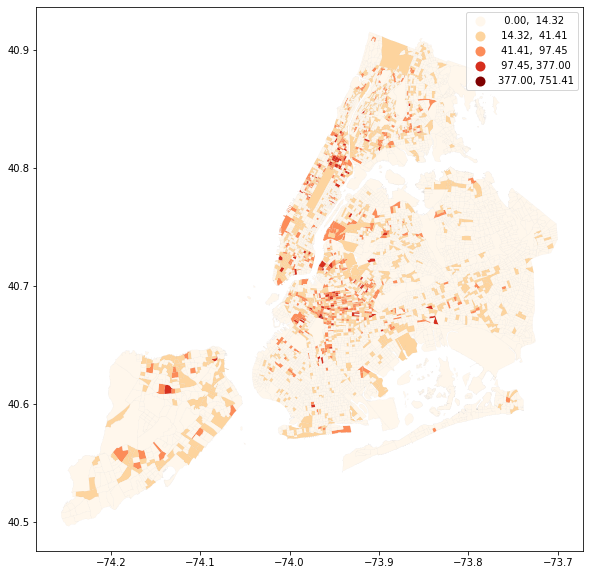

In [482]:
fig, ax = plt.subplots(figsize=(10, 10))
rodents_joined_tracts_gdf.plot(column='rats_weighted', 
                 scheme='natural_breaks', 
                 k=5, 
                 cmap='OrRd', 
                 edgecolor='k', 
                 ax=ax,
                 linewidth=0.01,
                 legend=True)

In [483]:
# Choose columns 

cols = ['rats_weighted']

rodents_gdf = rodents_joined_tracts_gdf[rodents_joined_tracts_gdf.geometry.notnull()]

original_crs = rodents_gdf.crs
equal_area_crs = {'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True}

# Make a copy of your original GeoDataFrame and reproject it
rodents_gdf_equal_area = rodents_gdf.to_crs(equal_area_crs)

# Check the new CRS
print(rodents_gdf_equal_area.crs)

# Only num rodent violations as a weight
cols = cols

# Extract the coordinates of the points
rodents_gdf['x'] = rodents_gdf.apply(lambda x: (x['geometry'].centroid.x), axis=1)
rodents_gdf['y'] = rodents_gdf.apply(lambda x: (x['geometry'].centroid.y), axis=1)

# Extract xy coordinates as features
X = rodents_gdf[['x', 'y']]

# Add additional variables to feature matrix
X = np.hstack((X, rodents_gdf[cols].values))

+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs


In [484]:
# Scale xy coordinates
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# Scale features so that distances are not overfitting larger values

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit the scaler to the data
scaler.fit(X)

# Transform the data using the scaler
X = scaler.transform(X)


<AxesSubplot:>

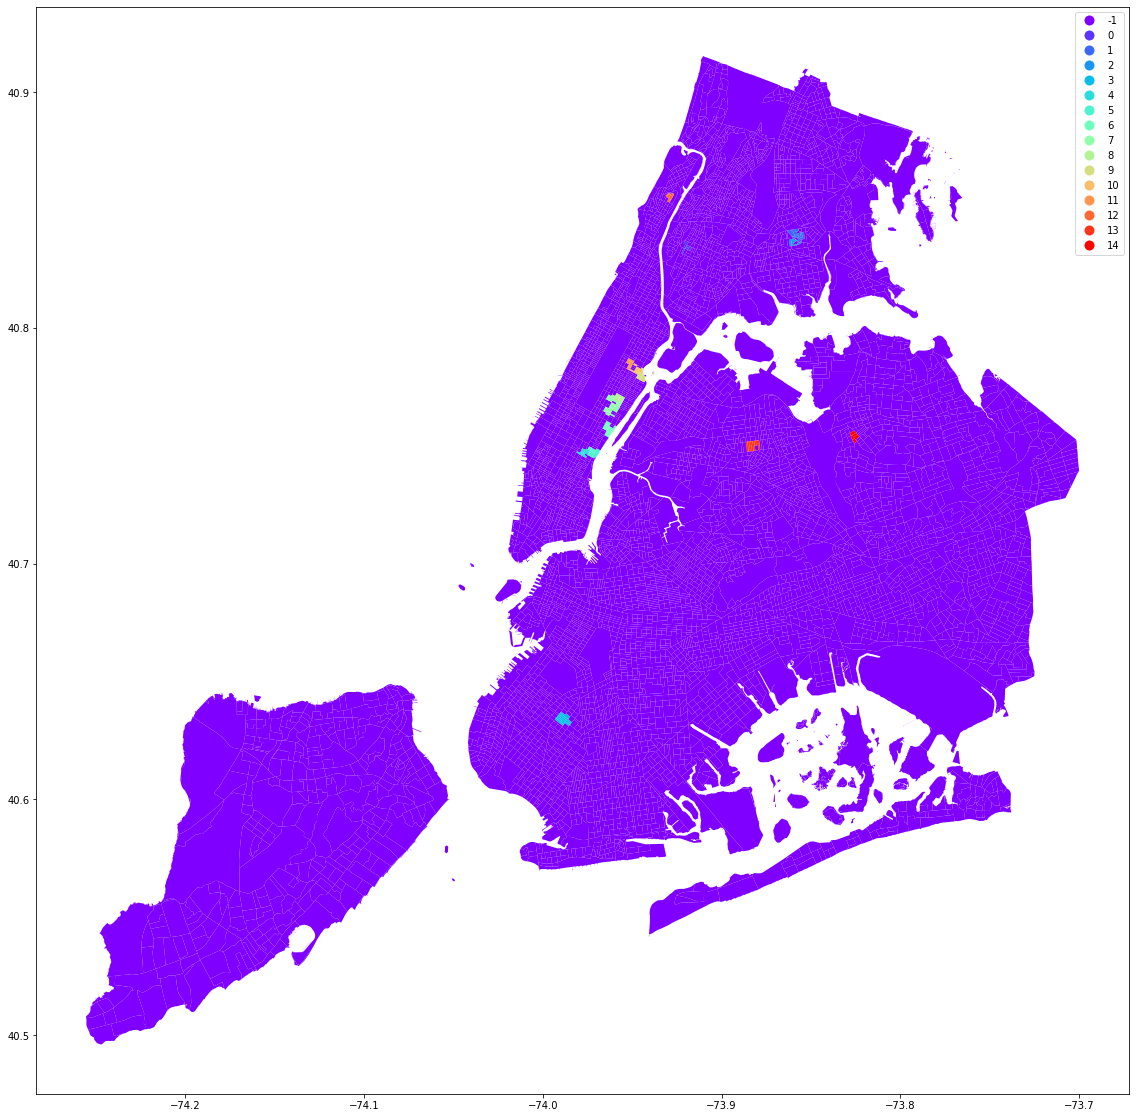

In [516]:
# # Run DBSCAN (Manual Tests)
dbscan = DBSCAN(eps=0.005, min_samples=5) 
labels = dbscan.fit_predict(X)
rodents_gdf['dbscan_clusters'] = labels
rodents_gdf.plot(column='dbscan_clusters', cmap='rainbow', categorical=True, figsize=(20, 20), legend=True)

In [486]:
# Define the hyperparameter search space
eps_values = np.arange(0.0005, 0.2, 0.005)
min_samples_values = np.arange(3, 20, 4)

# Initialize variables to store the best hyperparameters and their corresponding scores
best_eps = None
best_min_samples = None
best_silhouette = -1
best_calinski_harabasz = -1
best_davies_bouldin = float('inf')

# Perform a grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Ignore cases where all data points are assigned to the same cluster (noise)
        if len(set(labels)) > 1:
            silhouette = silhouette_score(X, labels)
            calinski_harabasz = calinski_harabasz_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)

            # Update the best hyperparameters if the current combination yields better scores
            if silhouette > best_silhouette:
                print('silhouette {0} {1} {2}'.format(silhouette, eps, min_samples))
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples

            if calinski_harabasz > best_calinski_harabasz:
                print('calinski_harabasz {0} {1} {2}'.format(calinski_harabasz, eps, min_samples))
                best_calinski_harabasz = calinski_harabasz
                best_eps = eps
                best_min_samples = min_samples

            if davies_bouldin < best_davies_bouldin:
                print('davies_bouldin {0} {1} {2}'.format(davies_bouldin, eps, min_samples))
                best_davies_bouldin = davies_bouldin
                best_eps = eps
                best_min_samples = min_samples

# Print the best hyperparameters and their corresponding scores
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)
print("Best Silhouette Score:", best_silhouette)
print("Best Calinski-Harabasz Index:", best_calinski_harabasz)
print("Best Davies-Bouldin Index:", best_davies_bouldin)


silhouette -0.4516015663287392 0.01 3
calinski_harabasz 34.784114124239615 0.01 3
davies_bouldin 1.9356294855185407 0.01 3
davies_bouldin 1.6778483743878403 0.01 7
davies_bouldin 1.5306073493144974 0.01 11
silhouette -0.3864510177386041 0.01 15
davies_bouldin 1.479195834253792 0.01 15
silhouette -0.37361355151494446 0.01 19
davies_bouldin 1.4602922783800374 0.015 3
calinski_harabasz 163.4477702507768 0.015 7
silhouette -0.287941844216594 0.015 11
calinski_harabasz 172.1037932084414 0.015 11
silhouette -0.2309965231126763 0.019999999999999997 15
silhouette -0.18312971402889236 0.019999999999999997 19
calinski_harabasz 370.6909506042854 0.019999999999999997 19
silhouette 0.10477508134608254 0.024999999999999998 7
davies_bouldin 1.3747836910994036 0.024999999999999998 7
davies_bouldin 1.289036278882187 0.024999999999999998 11
silhouette 0.13808120264692444 0.03 7
calinski_harabasz 462.99855204674606 0.03 7
silhouette 0.17743110504454476 0.03 11
calinski_harabasz 510.30759685743436 0.03 11

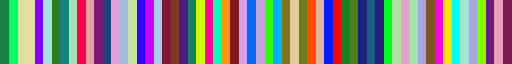

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, hsv_to_rgb

# Number of distinct colors you need
n_colors = 20
hues = np.linspace(0, 1, n_colors + 1)[:-1]
hsv_colors = np.zeros((n_colors, 3))
hsv_colors[:, 0] = hues
hsv_colors[:, 1] = 0.99
hsv_colors[:, 2] = 0.99 
rgb_colors1 = hsv_to_rgb(hsv_colors)

hsv_colors2 = np.zeros((n_colors, 3))
hsv_colors2[:, 0] = hues
hsv_colors2[:, 1] = 0.3
hsv_colors2[:, 2] = 0.9 
rgb_colors2 = hsv_to_rgb(hsv_colors2)

hsv_colors3 = np.zeros((n_colors, 3))
hsv_colors3[:, 0] = hues
hsv_colors3[:, 1] = 0.8
hsv_colors3[:, 2] = 0.5
rgb_colors3 = hsv_to_rgb(hsv_colors3)

colors = np.vstack([rgb_colors1,rgb_colors2,rgb_colors3])
np.random.shuffle(colors)

# Create a custom colormap using the generated colors
custom_cmap = ListedColormap(colors)
custom_cmap

<AxesSubplot:>

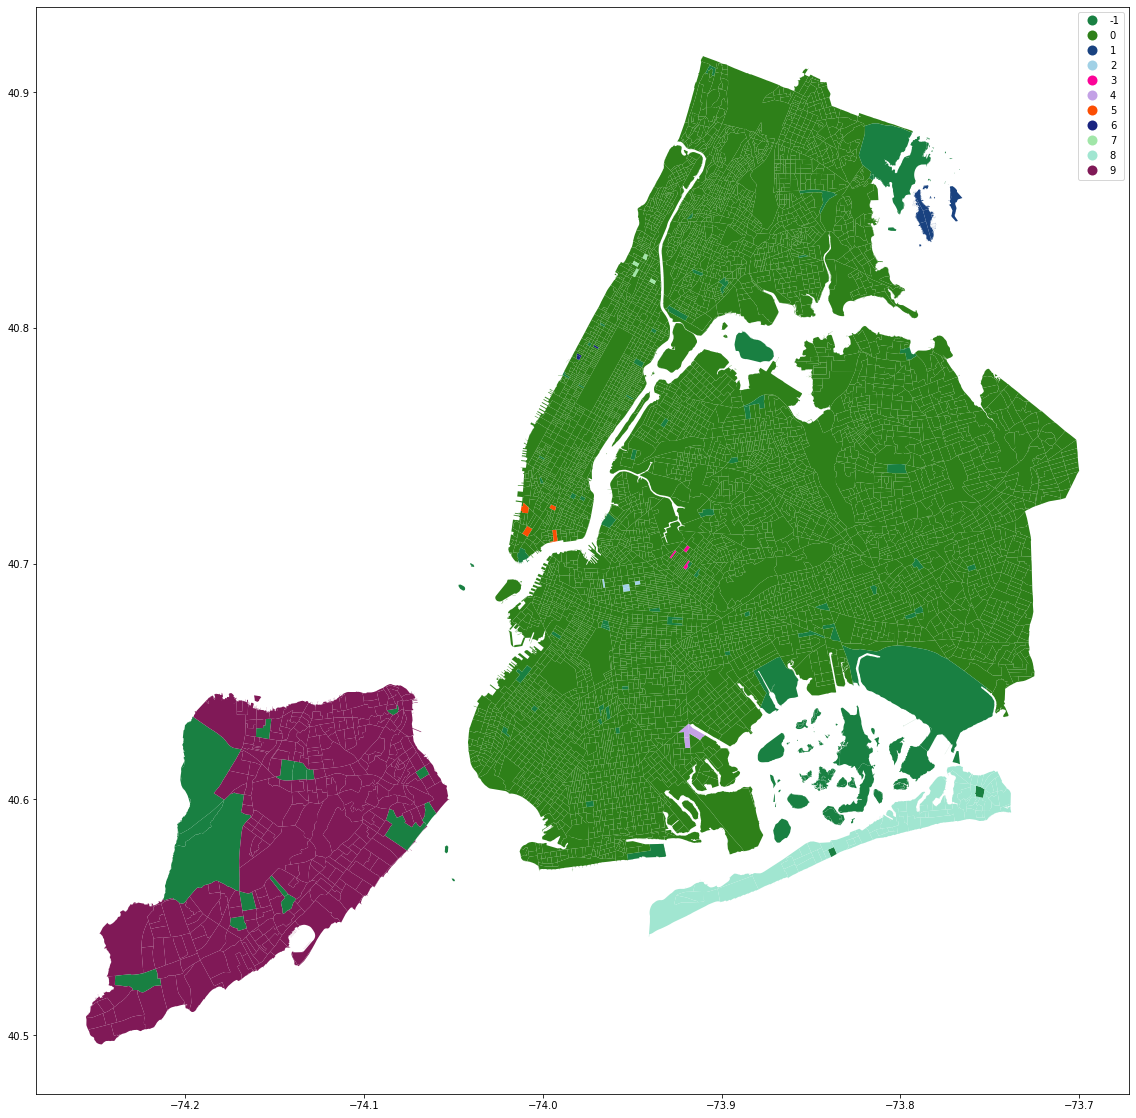

In [494]:
# Apply the hyperparameters 

# Run DBSCAN
dbscan = DBSCAN(eps=0.03, min_samples=3)  

labels = dbscan.fit_predict(X)

rodents_gdf['dbscan_clusters'] = labels

rodents_gdf.plot(column='dbscan_clusters', cmap=custom_cmap, categorical=True, figsize=(20, 20), legend=True)

In [495]:
rodents_gdf['is_dbscan_noise'] = rodents_gdf.apply(lambda x: True if x['dbscan_clusters']<0 else False, axis=1)
dbscan_noise_df = rodents_gdf.groupby(['is_dbscan_noise'])['num_sightings'].count().reset_index()
total_sightings = dbscan_noise_df.num_sightings.sum()
dbscan_noise_df['sightings_percent'] = dbscan_noise_df['num_sightings'] / total_sightings
dbscan_noise_df

,is_dbscan_noise,num_sightings,sightings_percent
0,False,6372,0.98592
1,True,91,0.01408


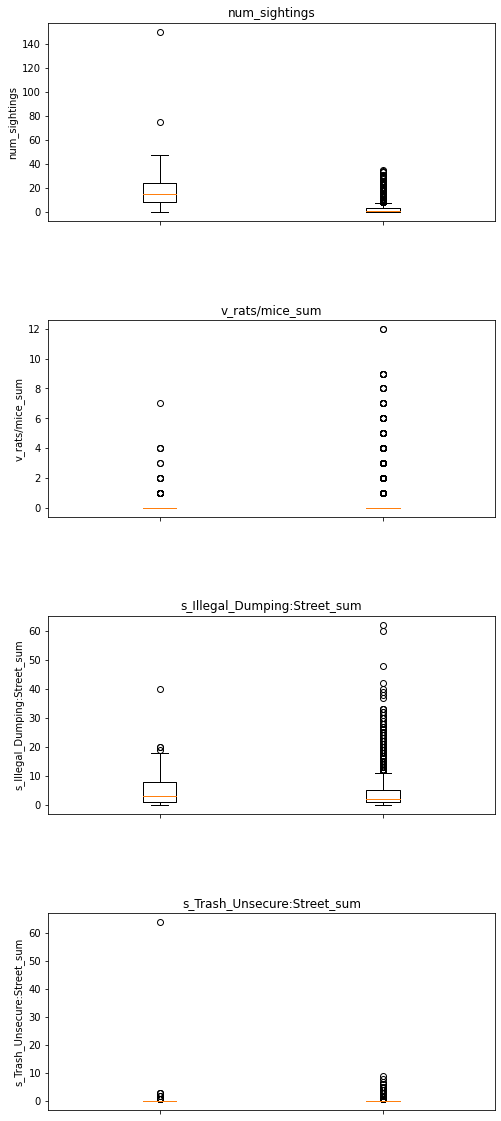

In [496]:
# Set up subplots for each variable
fig, axs = plt.subplots(nrows=len(cols_simple), figsize=(8, 5*len(cols_simple)))
plt.subplots_adjust(hspace=0.5)

# Loop over variables and create box and whisker plot for each
for i, col in enumerate(cols_simple):
    # Create a list of dataframes for each cluster
    group_dfs = []
    group = [True, False]
    for group in group:
        group_df = rodents_gdf[rodents_gdf['is_dbscan_noise'] == group]
        group_dfs.append(group_df)
        
    # Plot box and whisker for each cluster
    axs[i].boxplot([df[col] for df in group_dfs])
    cluster_labels = ['Cluster {}'.format(str(i)) for i in range(group)]
    axs[i].set_xticklabels(cluster_labels)
    axs[i].set_title(col)
    axs[i].set_ylabel(col)
    
plt.show()

In [497]:
# TODO Describe these clusters

# What percent of rodent complaints happen in these xx percent of census tracts

# Can i find which eps and min samples gives the 80/20 rule. 
# 80% of the complaints happening in 20% of the census tracts? Does the pareto rule apply? Seems like no. 

# DBSCAN Anomalies

To determine which areas had the most anamoulous rodent sightings, 

Filter the clusters to only the ones where there are fewer than 5% of the census block groups as clusters(i.e. very few clusters). 

Iterate over all results of the anomalies to find all possible epsilon and min sample hyperparameters that result in anomalies. Then, summarize the number of times the census block group is identified as an anomaly. 

Take the results of the summarization and create a heat map (choropleth) to show where the anomalies occur. 

Run this over each year and compare the output maps.

This approach can help sanitation workers pinpoint intervention on hotspots and could be thought of as a form of ensemble anomaly detection, as it combines the results of multiple DBSCAN models with different hyperparameters to identify the most frequently occurring anomalies.

This method of analyzing rodent sightings could be considered as a form of ensemble anomaly detection since it iterates over multiple combinations of hyperparameters (epsilon and min_samples) to identify anomalies. The summarized results then indicate the consensus of these different models regarding the anomalous regions.

In [498]:
rodents_gdf['time_anomalous'] = 0

total_num_samples = len(X[:,0])
max_eps = 0.07 # Tight clusters 

for eps in np.logspace(np.log10(max_eps) - 3, np.log10(max_eps), 20):
    for min_samples in range(5, 200, 1):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        num_clustered = len(db.labels_[db.labels_ >= 0])
        if (num_clustered > 0) & (num_clustered < 0.05 * total_num_samples):
            print("eps =", eps, ", min_samples =", min_samples, ", num_detected_points =", len(db.labels_[db.labels_ >= 0]))
            rodents_gdf['dbscan_clusters'] = db.labels_
            
            # Update the time_anomalous column to count the number of times each row is flagged as an anomaly
            rodents_gdf['time_anomalous'] += np.where(rodents_gdf['dbscan_clusters'] > 0, 1, 0)



eps = 0.003818916346817961 , min_samples = 5 , num_detected_points = 13
eps = 0.005493319792460226 , min_samples = 5 , num_detected_points = 244
eps = 0.005493319792460226 , min_samples = 6 , num_detected_points = 110
eps = 0.005493319792460226 , min_samples = 7 , num_detected_points = 74
eps = 0.005493319792460226 , min_samples = 8 , num_detected_points = 43
eps = 0.005493319792460226 , min_samples = 9 , num_detected_points = 20
eps = 0.005493319792460226 , min_samples = 10 , num_detected_points = 10
eps = 0.00790186524179282 , min_samples = 9 , num_detected_points = 312
eps = 0.00790186524179282 , min_samples = 10 , num_detected_points = 179
eps = 0.00790186524179282 , min_samples = 11 , num_detected_points = 141
eps = 0.00790186524179282 , min_samples = 12 , num_detected_points = 116
eps = 0.00790186524179282 , min_samples = 13 , num_detected_points = 98
eps = 0.00790186524179282 , min_samples = 14 , num_detected_points = 75
eps = 0.00790186524179282 , min_samples = 15 , num_detecte

In [499]:
rodents_gdf.time_anomalous.value_counts()

0     5930
1      106
2       86
3       47
7       47
4       32
5       26
22      25
21      19
14      15
15      14
8       13
13      12
18      12
11      12
6       11
17      10
23      10
19      10
16       8
12       8
20       5
9        3
10       2
Name: time_anomalous, dtype: int64

In [587]:
# Define the color map with light gray and red
colors = [(0.8, 0.8, 0.8), 'red']
cmap = LinearSegmentedColormap.from_list('Custom', colors)

# Plot the data using the custom color map
fig, ax = plt.subplots(figsize=(6, 6))
rodents_gdf.plot(column='time_anomalous', 
                 scheme='natural_breaks', 
                 k=10, 
                 cmap=cmap, 
                 edgecolor='k', 
                 ax=ax,
                 linewidth=0.01,
                 legend=True)

# Save the figure as a PNG file
plt.savefig('rodent_anomalies.png', dpi=150, bbox_inches='tight')
plt.close()

plt.show()

In [501]:
fig, ax = plt.subplots(figsize=(6, 6))
rodents_gdf.plot(column='num_sightings', 
                 scheme='natural_breaks', 
                 k=5, 
                 cmap='OrRd', 
                 edgecolor='k', 
                 ax=ax,
                 linewidth=0.01,
                 legend=True)

# Save the figure as a PNG file
plt.savefig('rodent_sightings.png', dpi=150, bbox_inches='tight')
plt.close()

In [504]:
fig, ax = plt.subplots(figsize=(6, 6))
rodents_gdf.plot(column='rats_weighted', 
                 scheme='natural_breaks', 
                 k=5, 
                 cmap='OrRd', 
                 edgecolor='k', 
                 ax=ax,
                 linewidth=0.01,
                 legend=True)

# Save the figure as a PNG file
plt.savefig('rodent_sightings_weighted.png', dpi=150, bbox_inches='tight')
plt.close()

In [502]:
rodents_gdf['is_anamoulous'] = rodents_gdf.apply(lambda x: True if x['time_anomalous']>0 else False, axis=1)
anomolous_df = rodents_gdf.groupby(['is_anamoulous'])['num_sightings'].sum().reset_index()
total_sightings = anomolous_df.num_sightings.sum()
anomolous_df['sightings_percent'] = anomolous_df['num_sightings'] / total_sightings
anomolous_df

,is_anamoulous,num_sightings,sightings_percent
0,False,15384.0,0.97981
1,True,317.0,0.02019


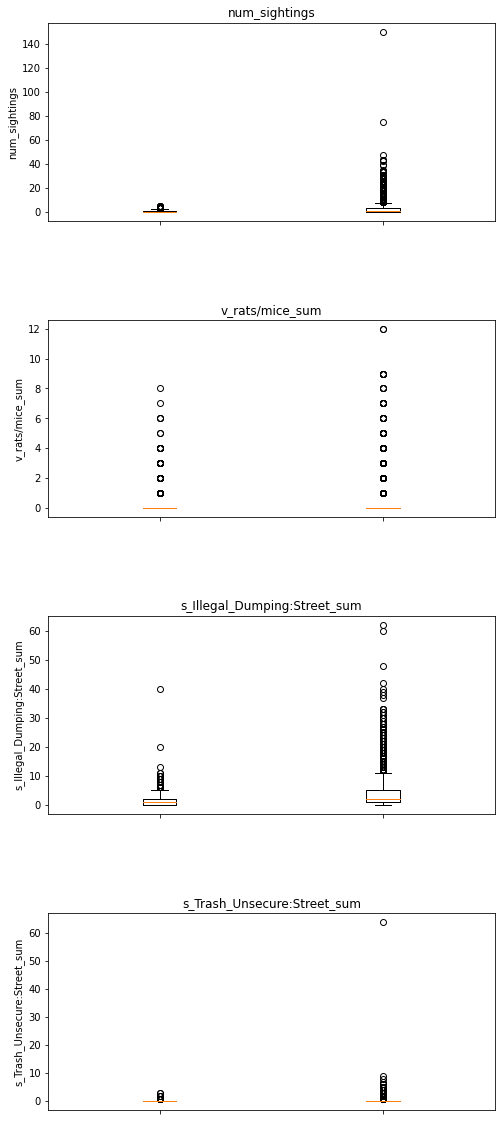

In [503]:
# Set up subplots for each variable
fig, axs = plt.subplots(nrows=len(cols_simple), figsize=(8, 5*len(cols_simple)))
plt.subplots_adjust(hspace=0.5)

# Loop over variables and create box and whisker plot for each
for i, col in enumerate(cols_simple):
    # Create a list of dataframes for each cluster
    group_dfs = []
    group = [True, False]
    for group in group:
        group_df = rodents_gdf[rodents_gdf['is_anamoulous'] == group]
        group_dfs.append(group_df)
        
    # Plot box and whisker for each cluster
    axs[i].boxplot([df[col] for df in group_dfs])
    cluster_labels = ['Cluster {}'.format(str(i)) for i in range(group)]
    axs[i].set_xticklabels(cluster_labels)
    axs[i].set_title(col)
    axs[i].set_ylabel(col)
    
plt.show()